In [85]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
from pybeerxml import Parser
import sys
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
sys.path.append('../')
from brewgen.backend.models import grain

In [86]:
# Get all recipe paths
beerxml_list = list(Path("./brewtoad_scrape").rglob("*.xml"))

In [87]:
parser = Parser()
recipe_db = []

In [88]:
rewrites = [
    {
        'name': 'Goldpils Vienna Malt',
        'match': "^.*(Goldpils|Vienna.*US|US.*Vienna|Briess.*Vienna|Vienna.*Briess).*$",
        'max_color': 6
    },
    # Weyermann as the catchall for Vienna
    {
        'name': 'Weyermann Vienna Malt',
        'match': '^.*Vienna.*$',
        'max_color': 6
    }, {
        'name': 'Weyermann Munich Malt I',
        "match": '^.*Munich.*$',
        'max_color': 7
    },
    {
        'name': 'Weyermann Munich Malt II',
        "match": '^.*Munich.*$',
        'max_color': 9.9
    },
    {
        'name': 'Munich Malt 10L',
        "match": '^.*Munich.*$',
        'max_color': 11
    },
    {
        'name': 'Munich Malt 20L',
        "match": '^.*Munich.*$',
        'max_color': 21
    },
    {
        'name': "Brewer's Malt",
        'match': '^.*(2|Two)(-| )Row.*$',
        'max_color': 2
    },
    # No sensory available for Maris Otter so lumping that in with Pale Ale Malt
    {
        'name': "Pale Ale Malt",
        'match': '^.*(Pale Ale|Maris).*$',
        'max_color': 5
    },
    {
        'name': "Carapils Malt",
        'match': '^.*(US.*Carapils|Carapils.*US|Carapils.*Briess|Briess.*Carapils).*$',
        'max_color': 5
    },
    # Weyermann as the catchall for Carapils
    {
        'name': "Weyermann Carapils",
        'match': '^.*(Carapils).*$',
        'max_color': 5
    },
    {
        'name': "Pilsen Malt",
        'match': '^.*(Pilsen|US.*Pilsner|Pilsner.*US).*$',
        'max_color': 3
    },
    # Weyermann as the catchall for Pilsner
    {
        'name': "Weyermann Pilsner Malt",
        'match': '^.*Pilsner.*$',
        'max_color': 3
    },
    {
        'name': "Pale Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 240
    },
    {
        'name': "Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 360
    },
    # Dark chocolate as the chocolate catchall
    {
        'name': "Dark Chocolate Malt",
        'match': '^.*Chocolate.*$',
    },
    {
        'name': "Special B",
        'match': '^.*Special (W|B).*$'
    },
    {
        'name': "Wheat Malt, White",
        'match': '^.*(White Wheat|Pale Wheat|Wheat Malt|Light Wheat|Wheat.*US).*$'
    },
    {
        'name': "Wheat Malt, Red",
        'match': '^.*(Red.*Wheat|Wheat.*Red|).*$'
    },
    {
        'name': "Brewers Torrified Wheat",
        'match': '^.*(Wheat.*Torrified|Torrified Wheat).*$'
    },
    {
        'name': "Weyermann Pale Wheat Malt",
        'match': '^.*((Belgian|German).*Wheat|Wheat.*(DE|BE|Belgian|German)).*$'
    },
    {
        'name': "Dextrose (Corn Sugar)",
        'match': '^.*(Corn Sugar|Dextrose).*$'
    },
    {
        'name': "Brewers Barley Flakes",
        'match': '^.*(Barley.*Flaked|Flaked.*Barley).*$'
    },
    {
        'name': "Brewers Oat Flakes",
        'match': '^.*(Oat.*Flaked|Flaked.*Oat).*$'
    },
    {
        'name': "Honey Malt",
        'match': '^.*(Honey.*Malt|Malt.*Honey|Honey.*US|Honey.*CA|Honey.*Gambrinus|Gambrinus.*Honey).*$'
    },
    {
        'name': 'Victory Malt',
        'match': '^.*Victory.*$'
    }
]

# Add rewrites for each Crystal malt
for lov in [10, 20, 30, 40, 60, 80, 90, 120]:
    rewrites.append({
        'name': 'Caramel Malt {}L'.format(lov),
        'match': '^.*(Caramel|Crystal).*{}.*$'.format(lov)
    })

In [89]:
for beerxml_file in beerxml_list[0:100000]:
    try:
        recipes = parser.parse('./{}'.format(str(beerxml_file)))
    except:
        print("Failed to parse ./{}".format(str(beerxml_file)))
        recipes = []
    
    for recipe in recipes:
        try:
            style = recipe.style.name
            fermentables = []
            total_amount = sum(
                fermentable.amount for fermentable in recipe.fermentables)
            for fermentable in recipe.fermentables:
                fermentable_name = fermentable.name
                # Remove all LME/DME
                extract = re.match("^.*(CBW|DME|LME|Extract|Malt Syrup).*$", fermentable_name)
                if extract:
                    #print('Skipping extract: {}'.format(fermentable_name))
                    break
                
                # Rewrite fermentable names
                for rule in rewrites:
                    match = re.match(rule['match'], fermentable.name)
                    if match and fermentable.color <= rule.get('max_color', 999):
                        #print('Rewriting {} -> {}'.format(fermentable_name, rule['name']))
                        fermentable_name = rule['name']
                        break

                fermentables.append({
                    'name': fermentable_name,
                    'percent': fermentable.amount / total_amount * 100,
                    'color': fermentable.color,
                    'ppg': fermentable.ppg,
                    'addition': fermentable.addition,
                })
            recipe_db.append({
                'style': style,
                'category': recipe.style.category,
                'og': recipe.og,
                'color': recipe.color,
                'fermentables': fermentables
            })
        except:
            print("Failed to parse recipe in ./{}".format(str(beerxml_file)))

Failed to parse ./brewtoad_scrape/recipes/beginers-luck-ipa-2012-02-19-vers/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/ipa-2-huell-melon-galaxy/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/cascadia-pale-ale-20/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/delta-hoppy-blonde/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/seriously-mild/recipe.xml


In [90]:
# Get an array of styles and color histogram data
styles = np.unique(np.array([recipe['style'] for recipe in recipe_db]))
color_data = [[recipe['color'] for recipe in recipe_db if recipe['style'] == style] for style in styles]

In [91]:
# Create a list of list of dicts containing grains and their usage percents for every style and recipe
# [Style:[Grains:{Name, Usage Percent}]]
fermentable_data = []
for i in range(len(styles)):
    fermentable_style_data = []
    recipe_fermentables = [recipe['fermentables'] for recipe in recipe_db if recipe['style'] == styles[i]]
    for recipe in recipe_fermentables:
        for fermentable in recipe:
            fermentable_style_data.append(fermentable)
    fermentable_data.append(fermentable_style_data)

In [92]:
# # Histograms for the SRM data for each style
# plt.xlabel('SRM')
# plt.ylabel('Counts')
# bins = range(0, 101)
# for i in range(len(styles)):
#     data = color_data[i]
#     plt.title(styles[i])
#     plt.hist(color_data[i], bins=bins)
#     plt.show()
#     std_dev = np.std(color_data[i])
#     mean = np.mean(color_data[i])
#     print('Mean: {}'.format(mean))
#     print('Standard Dev: {}'.format(std_dev))
#     print('Range (1 std dev): {} - {}'.format(mean - .5 * std_dev, mean + .5 * std_dev))

In [93]:
# Plot grain usage for each style 
for style in range(len(styles)):
    # Only calculate for American Pale Ale for now
    if styles[style] == 'American IPA':
        # Get unique fermentable names
        names = [fermentable['name'] for fermentable in fermentable_data[style]]
        unique_names = list(set(names))
        fermentable_usage = []
        for name in range(len(unique_names)):
            usage_list = [fermentable['percent'] for fermentable in fermentable_data[style] if fermentable['name'] == unique_names[name]]
            fermentable_usage.append((unique_names[name],usage_list))
            
# Sort by the most common grain names, then plot usage averages
sorted_usage = sorted(fermentable_usage, key=lambda tup: len(tup[1]), reverse=True)

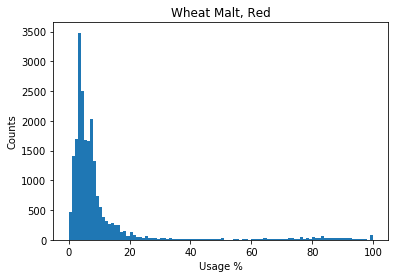

Mean: 10.618410278039306
Standard Dev: 17.088005678728855
Range (3 std dev): 0-61%


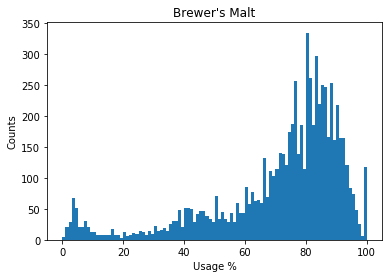

Mean: 71.42805187581541
Standard Dev: 21.77288627889308
Range (3 std dev): 6-100%


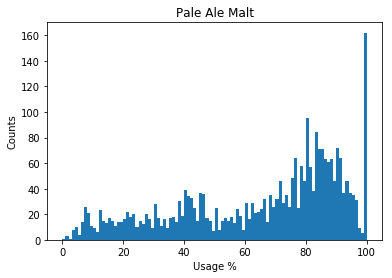

Mean: 65.2811423927359
Standard Dev: 26.775052746384933
Range (3 std dev): 0-100%


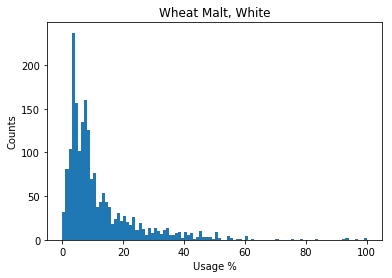

Mean: 11.85541307058592
Standard Dev: 12.175382621735077
Range (3 std dev): 0-48%


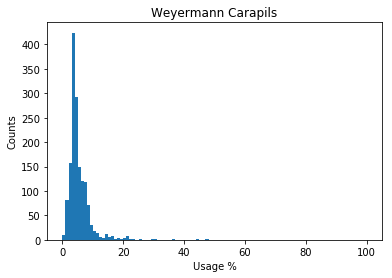

Mean: 5.299203309456483
Standard Dev: 3.7139492916266557
Range (3 std dev): 0-16%


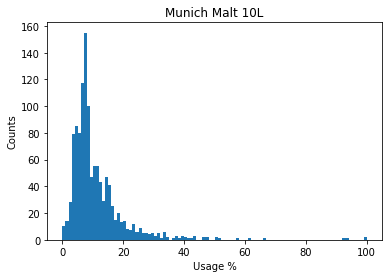

Mean: 11.0448850267612
Standard Dev: 9.466392439157786
Range (3 std dev): 0-39%


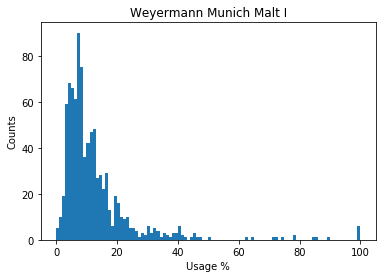

Mean: 12.769056331368038
Standard Dev: 12.914717725363108
Range (3 std dev): 0-51%


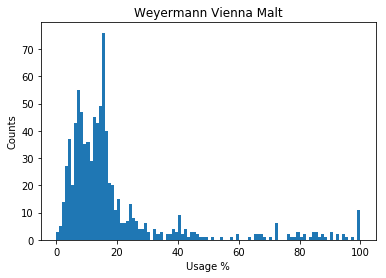

Mean: 18.943330622486368
Standard Dev: 19.89846928010709
Range (3 std dev): 0-78%


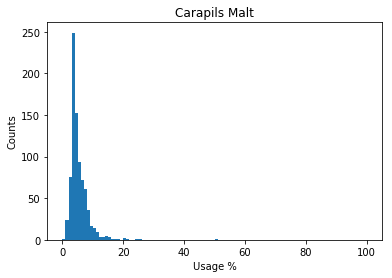

Mean: 5.246378697080701
Standard Dev: 3.190256028047294
Range (3 std dev): 0-14%


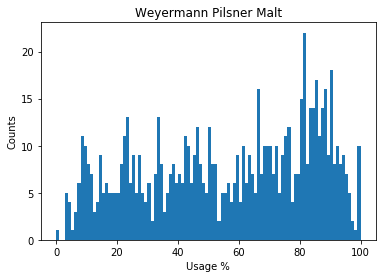

Mean: 56.33469373019342
Standard Dev: 27.466976198124154
Range (3 std dev): 0-100%


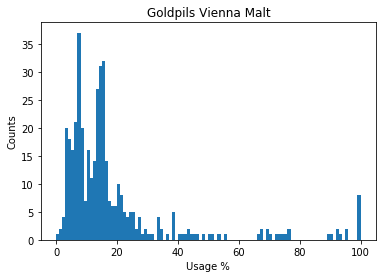

Mean: 18.906811229329154
Standard Dev: 20.24747948335906
Range (3 std dev): 0-79%


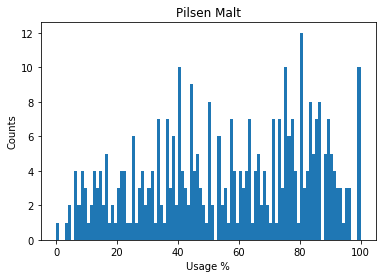

Mean: 56.16905441277373
Standard Dev: 26.666637066585075
Range (3 std dev): 0-100%


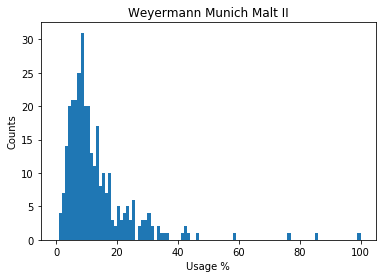

Mean: 13.047358736091606
Standard Dev: 11.361361382937952
Range (3 std dev): 0-47%


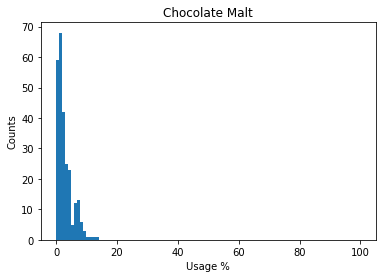

Mean: 2.947755504762746
Standard Dev: 2.4739884475538836
Range (3 std dev): 0-10%


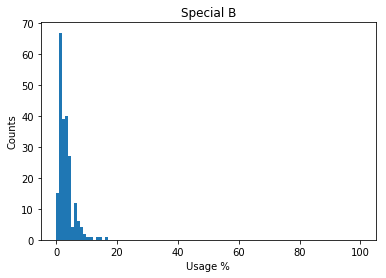

Mean: 3.3230376278780174
Standard Dev: 2.44933782218698
Range (3 std dev): 0-10%


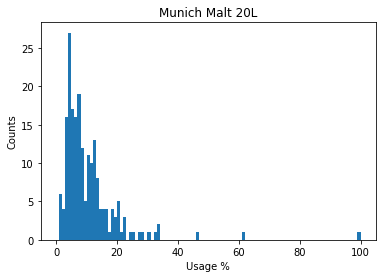

Mean: 10.560798359103353
Standard Dev: 9.983513508881487
Range (3 std dev): 0-40%


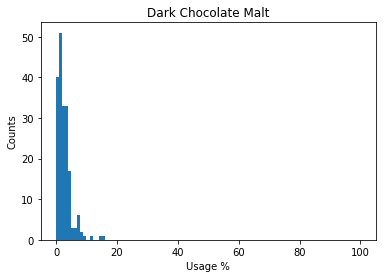

Mean: 2.7202731398799926
Standard Dev: 2.2948236150279815
Range (3 std dev): 0-9%


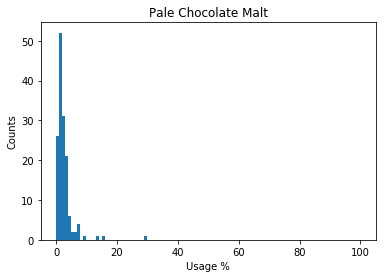

Mean: 2.6736464749530815
Standard Dev: 3.074791659291472
Range (3 std dev): 0-11%


In [94]:
for fermentable_usage in sorted_usage[0:50]:
    # Histogram for the grain usage 
    #plt.title('{} in {}'.format(unique_names[name], styles[style]))
    plt.title('{}'.format(fermentable_usage[0]))
    plt.xlabel('Usage %')
    plt.ylabel('Counts')
    bins = range(0, 101)
    plt.hist(fermentable_usage[1], bins=bins)
    plt.show()
    std_dev = np.std(fermentable_usage[1])
    mean = np.mean(fermentable_usage[1])
    print('Mean: {}'.format(mean))
    print('Standard Dev: {}'.format(std_dev))
    print('Range (3 std dev): {}-{}%'.format(max(0, int(mean - 3 * std_dev)), min(100, int(mean + 3 * std_dev))))